In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

In [2]:
# device.py
import torch

try:
    import torch_directml
    device = torch_directml.device()
    print("Using AMD DirectML GPU")
except:
    device = torch.device("cpu")
    print("Using CPU")

Using AMD DirectML GPU


In [3]:
IMG_SIZE = 160

def load_data(image_path, mask_path):
    images = []
    masks = []

    image_files = sorted(os.listdir(image_path))

    for img_name in image_files:
        img_path = os.path.join(image_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue

        base = os.path.splitext(img_name)[0]
        mask_name = base + "_segmentation.png"
        mask_path_full = os.path.join(mask_path, mask_name)
        mask = cv2.imread(mask_path_full, 0)
        if mask is None:
            continue

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0

        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
        mask = mask / 255.0
        mask = np.expand_dims(mask, axis=-1)

        images.append(img)
        masks.append(mask)

    return np.array(images, dtype=np.float32), np.array(masks, dtype=np.float32)

X, y = load_data(
    "data/archive/ISIC2018_Task1-2_Training_Input",
    "data/archive/ISIC2018_Task1_Training_GroundTruth"
)

print("Images:", X.shape)
print("Masks:", y.shape)

Images: (2594, 160, 160, 3)
Masks: (2594, 160, 160, 1)


In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [5]:
def dice_coef(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    return (2. * intersection + 1e-6) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1e-6
    )

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [6]:
def build_resnet_unet_cpu(input_shape=(160,160,3)):

    base_model = ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape
    )

    base_model.trainable = False

    # Encoder
    c1 = base_model.get_layer("conv1_relu").output
    c2 = base_model.get_layer("conv2_block3_out").output
    c3 = base_model.get_layer("conv3_block4_out").output
    c4 = base_model.get_layer("conv4_block6_out").output
    c5 = base_model.get_layer("conv5_block3_out").output

    # Decoder
    u6 = layers.UpSampling2D()(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(256, 3, activation="relu", padding="same")(u6)

    u7 = layers.UpSampling2D()(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(128, 3, activation="relu", padding="same")(u7)

    u8 = layers.UpSampling2D()(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(64, 3, activation="relu", padding="same")(u8)

    u9 = layers.UpSampling2D()(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(32, 3, activation="relu", padding="same")(u9)

    # Final upsampling to original resolution
    u10 = layers.UpSampling2D()(c9)
    outputs = layers.Conv2D(1, 1, activation="sigmoid")(u10)

    return models.Model(base_model.input, outputs)

In [7]:
model = build_resnet_unet_cpu()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=dice_loss,
    metrics=[dice_coef]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 166, 166,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 80, 80,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 80, 80,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 80, 80,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 82, 82,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 40, 40,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 40, 40,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 40, 40,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 40, 40,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 40, 40,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 40, 40,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 40, 40,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 40, 40,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 40, 40,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 40, 40,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 40, 40,    │      1,024 │ conv2_block1_3_c

 Total params: 31,808,897 (121.34 MB)

 Trainable params: 8,221,185 (31.36 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=16
)


Epoch 1/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - dice_coef: 0.5779 - loss: 0.4223 - val_dice_coef: 0.5864 - val_loss: 0.4145
Epoch 2/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - dice_coef: 0.5803 - loss: 0.4198 - val_dice_coef: 0.5878 - val_loss: 0.4131
Epoch 3/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - dice_coef: 0.5807 - loss: 0.4194 - val_dice_coef: 0.5823 - val_loss: 0.4186
Epoch 4/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - dice_coef: 0.5835 - loss: 0.4167 - val_dice_coef: 0.5907 - val_loss: 0.4102
Epoch 5/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - dice_coef: 0.5870 - loss: 0.4131 - val_dice_coef: 0.6034 - val_loss: 0.3976
Epoch 6/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - dice_coef: 0.5871 - loss: 0.4133 - val_dice_coef: 0.5963 - val_loss: 0.4047
Epoch 7/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - dice_coef: 0.5910 - loss: 0.4089 - val_dice_coef: 0.6036 - val_loss: 0.3974
Epoch 8/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - dice_coef: 0.5979 - loss: 0.

In [11]:
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)
model.save(os.path.join(model_dir, "resnet_unet_baseline.keras"))
print("Saved baseline model to models/resnet_unet_baseline.keras")

Saved baseline model to models/resnet_unet_baseline.keras


In [10]:
def iou_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection

    return intersection / (union + 1e-6)

preds = model.predict(X_val)

print("Validation Dice:", dice_coef(y_val, preds).numpy())
print("Validation IoU:", iou_score(y_val, preds).numpy())

17/17 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step
Validation Dice: 0.7363198
Validation IoU: 0.58677554


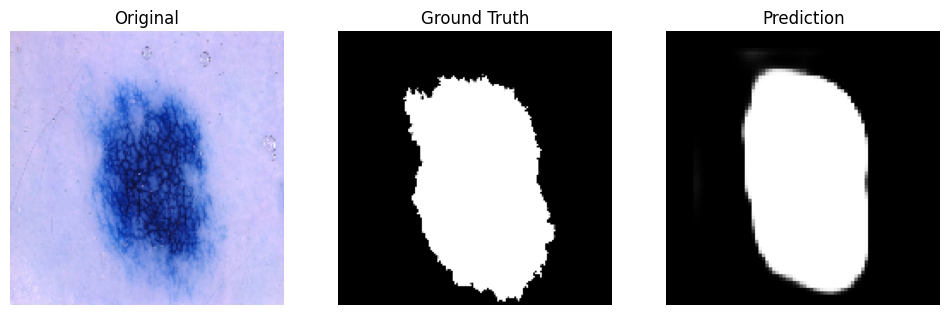

In [16]:
def show_prediction(index):
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.imshow(X_val[index])
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(y_val[index].squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(preds[index].squeeze(), cmap='gray')
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

show_prediction(15)

## Brightness Augmentation

In [17]:
brightness_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    brightness_range=[0.8, 1.2]
)

In [18]:
def segmentation_generator(images, masks, batch_size):
    while True:
        idx = np.random.randint(0, len(images), batch_size)

        batch_images = images[idx]
        batch_masks = masks[idx]

        augmented_images = []

        for img in batch_images:
            img_aug = brightness_datagen.random_transform(img)
            augmented_images.append(img_aug)

        augmented_images = np.array(augmented_images, dtype=np.float32)

        yield augmented_images, batch_masks

In [19]:
model_bright = build_resnet_unet_cpu()

model_bright.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=dice_loss,
    metrics=[dice_coef]
)

In [20]:
batch_size = 16

train_gen = segmentation_generator(X_train, y_train, batch_size)

history_bright = model_bright.fit(
    train_gen,
    steps_per_epoch=len(X_train)//batch_size,
    validation_data=(X_val, y_val),
    epochs=30
)

model_dir = "models"
os.makedirs(model_dir, exist_ok=True)
model_bright.save(os.path.join(model_dir, "resnet_unet_brightness.keras"))
print("Saved brightness model to models/resnet_unet_brightness.keras")

Epoch 1/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - dice_coef: 0.5567 - loss: 0.4433 - val_dice_coef: 0.5837 - val_loss: 0.4191
Epoch 2/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - dice_coef: 0.5757 - loss: 0.4243 - val_dice_coef: 0.5832 - val_loss: 0.4192
Epoch 3/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - dice_coef: 0.5795 - loss: 0.4205 - val_dice_coef: 0.5872 - val_loss: 0.4152
Epoch 4/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - dice_coef: 0.5729 - loss: 0.4271 - val_dice_coef: 0.5871 - val_loss: 0.4153
Epoch 5/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - dice_coef: 0.5804 - loss: 0.4196 - val_dice_coef: 0.5894 - val_loss: 0.4131
Epoch 6/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - dice_coef: 0.5806 - loss: 0.4194 - val_dice_coef: 0.5887 - val_loss: 0.4137
Epoch 7/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - dice_coef: 0.5749 - loss: 0.4251 - val_dice_coef: 0.5897 - val_loss: 0.4128
Epoch 8/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - dice_coef: 0.5780 - loss: 0.

In [21]:
preds_bright = model_bright.predict(X_val)

print("Brightness Dice:", dice_coef(y_val, preds_bright).numpy())
print("Brightness IoU:", iou_score(y_val, preds_bright).numpy())

17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step
Brightness Dice: 0.58769494
Brightness IoU: 0.41608676


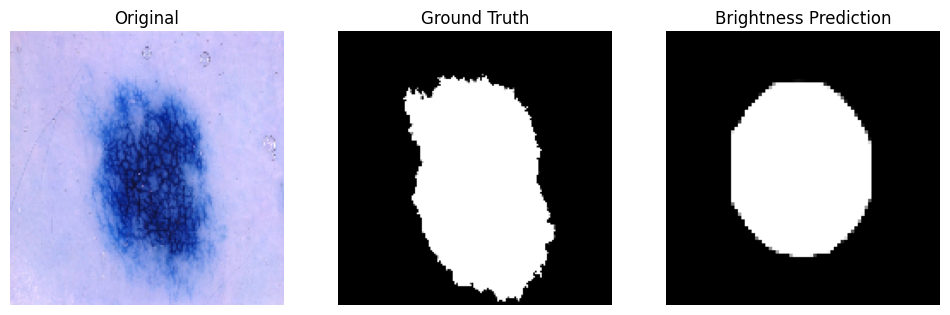

In [22]:
def show_brightness_prediction(index):
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.imshow(X_val[index])
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(y_val[index].squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(preds_bright[index].squeeze(), cmap='gray')
    plt.title("Brightness Prediction")
    plt.axis("off")

    plt.show()

show_brightness_prediction(15)

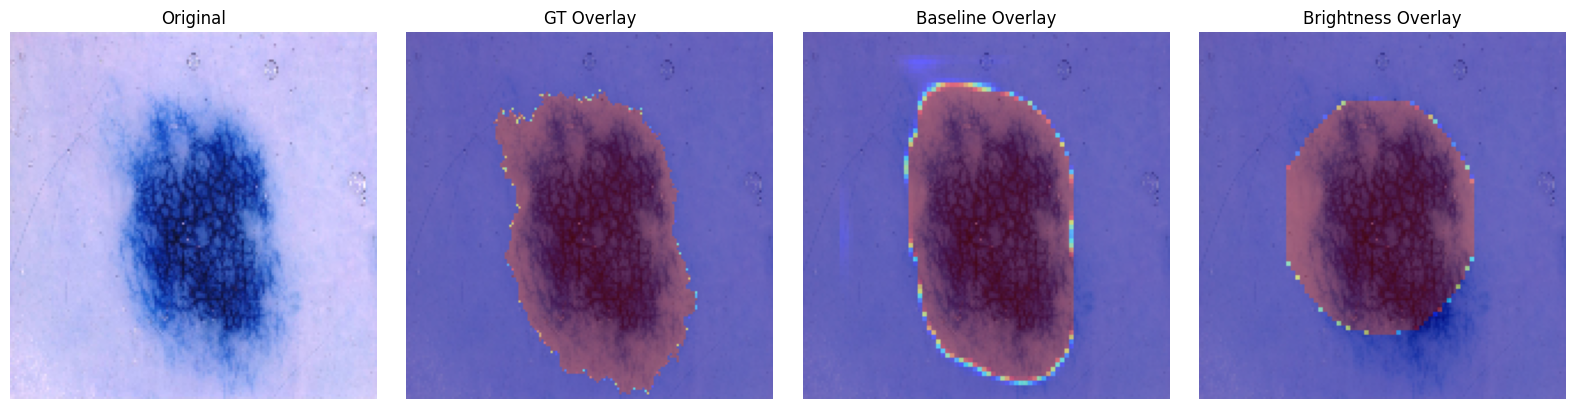

In [23]:
def show_overlay_comparison(index):
    plt.figure(figsize=(16,4))

    original = X_val[index]
    gt = y_val[index].squeeze()
    base_pred = preds[index].squeeze()
    bright_pred = preds_bright[index].squeeze()

    # Original
    plt.subplot(1,4,1)
    plt.imshow(original)
    plt.title("Original")
    plt.axis("off")

    # Ground Truth Overlay
    plt.subplot(1,4,2)
    plt.imshow(original)
    plt.imshow(gt, cmap='jet', alpha=0.5)
    plt.title("GT Overlay")
    plt.axis("off")

    # Baseline Overlay
    plt.subplot(1,4,3)
    plt.imshow(original)
    plt.imshow(base_pred, cmap='jet', alpha=0.5)
    plt.title("Baseline Overlay")
    plt.axis("off")

    # Brightness Overlay
    plt.subplot(1,4,4)
    plt.imshow(original)
    plt.imshow(bright_pred, cmap='jet', alpha=0.5)
    plt.title("Brightness Overlay")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

show_overlay_comparison(15)

## Classification

In [59]:
import os
import tensorflow as tf
import torch
import torch.nn as nn
from torchvision import models as tv_models

model_dir = "models"

baseline_path = os.path.join(model_dir, "resnet_unet_baseline.keras")
bright_path = os.path.join(model_dir, "resnet_unet_brightness.keras")

custom_objects = {
    "dice_loss": dice_loss,
    "dice_coef": dice_coef
}

if os.path.exists(baseline_path):
    model = tf.keras.models.load_model(baseline_path, custom_objects=custom_objects)
    print(f"Loaded baseline model from {baseline_path}")
else:
    print(f"Baseline model not found at {baseline_path}")

if os.path.exists(bright_path):
    model_bright = tf.keras.models.load_model(bright_path, custom_objects=custom_objects)
    print(f"Loaded brightness model from {bright_path}")
else:
    print(f"Brightness model not found at {bright_path}")

pt_baseline_path = os.path.join(model_dir, "resnet18_baseline.pt")
pt_bright_path = os.path.join(model_dir, "resnet18_brightness.pt")

pt_device = device if "device" in globals() else torch.device("cpu")

def load_resnet18_checkpoint(path, num_classes=7):
    model_pt = tv_models.resnet18(weights=None)
    model_pt.fc = nn.Linear(model_pt.fc.in_features, num_classes)
    state = torch.load(path, map_location=pt_device)
    model_pt.load_state_dict(state)
    model_pt.to(pt_device)
    model_pt.eval()
    return model_pt

if os.path.exists(pt_baseline_path):
    classification_model = load_resnet18_checkpoint(pt_baseline_path)
    print(f"Loaded baseline classifier from {pt_baseline_path}")
else:
    print(f"Baseline classifier not found at {pt_baseline_path}")

if os.path.exists(pt_bright_path):
    classification_model_bright = load_resnet18_checkpoint(pt_bright_path)
    print(f"Loaded brightness classifier from {pt_bright_path}")
else:
    print(f"Brightness classifier not found at {pt_bright_path}")

Loaded baseline model from models\resnet_unet_baseline.keras
Loaded brightness model from models\resnet_unet_brightness.keras


C:\Users\charv\AppData\Local\Temp\ipykernel_22976\4053788742.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(path, map_location=pt_device)


Loaded baseline classifier from models\resnet18_baseline.pt
Loaded brightness classifier from models\resnet18_brightness.pt


In [60]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_path = r"data\archive\ISIC2018_Task1-2_Test_Input\ISIC_0021999.jpg"   # change to your image path

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Resize according to segmentation model input
image_resized = cv2.resize(image, (160,160))
image_norm = image_resized / 255.0

input_image = np.expand_dims(image_norm, axis=0)

In [63]:
pred_mask = model.predict(input_image)
pred_mask = (pred_mask > 0.35).astype(np.uint8)
pred_mask = pred_mask.squeeze()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


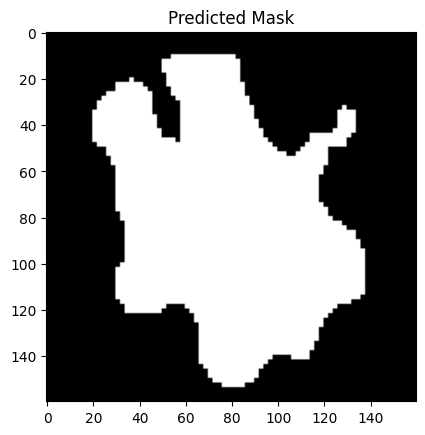

In [64]:
plt.imshow(pred_mask, cmap='gray')
plt.title("Predicted Mask")
plt.show()

In [65]:
coords = cv2.findNonZero(pred_mask)

if coords is not None:
    x, y, w, h = cv2.boundingRect(coords)
    cropped = image_resized[y:y+h, x:x+w]
else:
    cropped = image_resized  # fallback

In [66]:
cropped_resized = cv2.resize(cropped, (160,160))
cropped_norm = cropped_resized / 255.0
cropped_input = np.expand_dims(cropped_norm, axis=0)

In [72]:
import torch
import torch.nn.functional as F

# Use the ResNet18 baseline classifier (.pt)
model_pt = classification_model
model_pt.eval()

input_tensor = torch.from_numpy(cropped_input).permute(0, 3, 1, 2).float()
if input_tensor.shape[-1] != 224:
    input_tensor = F.interpolate(input_tensor, size=(224, 224), mode="bilinear", align_corners=False)

input_tensor = input_tensor.to(pt_device)

with torch.no_grad():
    logits = model_pt(input_tensor)
    probs = torch.softmax(logits, dim=1)
    predicted_class = int(torch.argmax(probs, dim=1).cpu().item())
    confidence = float(probs.max(dim=1).values.cpu().item())

print("Predicted Class Index:", predicted_class)
print("Confidence:", confidence)

Predicted Class Index: 5
Confidence: 0.9892228841781616


In [73]:
class_names = [
    "actinic_keratosis",
    "basal_cell_carcinoma",
    "dermatofibroma",
    "melanoma",
    "nevus",
    "pigmented_benign_keratosis",
    "squamous_cell_carcinoma",
    "vascular_lesion"
]

print("Predicted Class:", class_names[predicted_class])

Predicted Class: pigmented_benign_keratosis


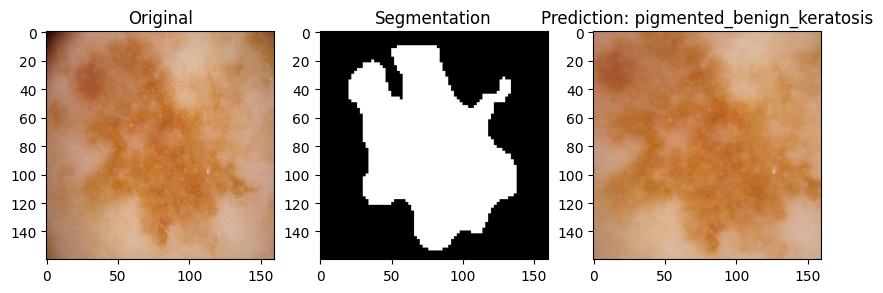

In [74]:
plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
plt.imshow(image_resized)
plt.title("Original")

plt.subplot(1,3,2)
plt.imshow(pred_mask, cmap='gray')
plt.title("Segmentation")

plt.subplot(1,3,3)
plt.imshow(cropped_resized)
plt.title(f"Prediction: {class_names[predicted_class]}")

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
Example image: ISIC_0012169.jpg
Baseline predicted class: basal_cell_carcinoma (confidence 0.558)
Brightness predicted class: dermatofibroma (confidence 0.384)


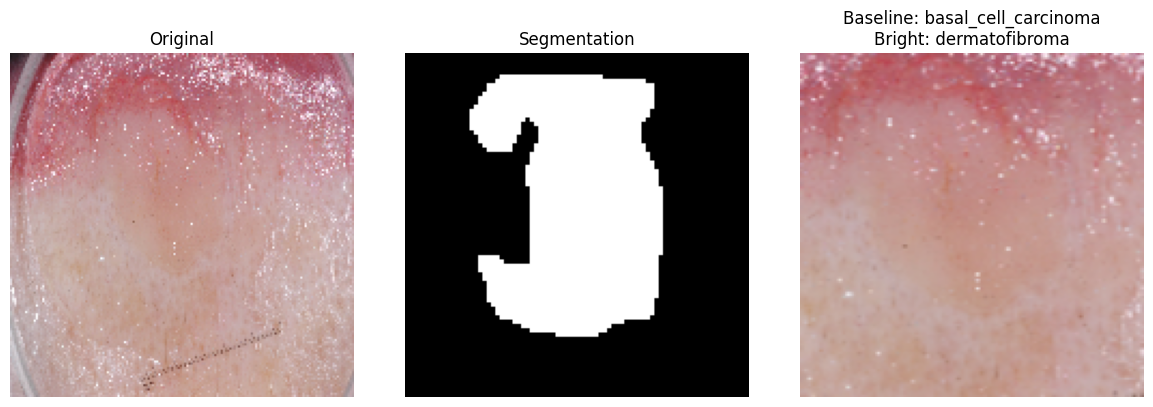

In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Pick one example image from the test folder with good confidence
TEST_DIR = os.path.join("data", "archive", "ISIC2018_Task1-2_Test_Input")
image_files = [f for f in os.listdir(TEST_DIR) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

if not image_files:
    raise FileNotFoundError(f"No images found in {TEST_DIR}")

if "class_names" not in globals():
    class_names = [
        "akiec",
        "bcc",
        "bkl",
        "df",
        "mel",
        "nv",
        "vasc"
    ]

# Try multiple images to find one with high confidence
max_conf = 0
best_example = None

for fname in sorted(image_files)[:20]:  # Check first 20 images
    fpath = os.path.join(TEST_DIR, fname)
    
    img = cv2.imread(fpath)
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_norm = img_resized / 255.0
    img_input = np.expand_dims(img_norm, axis=0)
    
    # Segmentation
    mask = model.predict(img_input, verbose=0)
    mask = (mask > 0.35).astype(np.uint8).squeeze()
    
    # Crop
    coords = cv2.findNonZero(mask)
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        crop = img_resized[y:y+h, x:x+w]
    else:
        crop = img_resized
    
    crop_resized = cv2.resize(crop, (IMG_SIZE, IMG_SIZE))
    crop_norm = crop_resized / 255.0
    crop_input = np.expand_dims(crop_norm, axis=0)
    
    tensor = torch.from_numpy(crop_input).permute(0, 3, 1, 2).float()
    if tensor.shape[-1] != 224:
        tensor = F.interpolate(tensor, size=(224, 224), mode="bilinear", align_corners=False)
    tensor = tensor.to(pt_device)
    
    with torch.no_grad():
        logits = classification_model(tensor)
        probs = torch.softmax(logits, dim=1)
        conf = float(probs.max(dim=1).values.cpu().item())
        
        if conf > max_conf:
            max_conf = conf
            best_example = {
                "name": fname,
                "image": img,
                "image_resized": img_resized,
                "mask": mask,
                "crop_resized": crop_resized,
                "tensor": tensor,
                "conf": conf,
                "idx": int(torch.argmax(probs, dim=1).cpu().item())
            }

if best_example is None:
    raise ValueError("No valid images found")

# Run brightness model on best example
with torch.no_grad():
    bright_logits = classification_model_bright(best_example["tensor"])
    bright_probs = torch.softmax(bright_logits, dim=1)
    bright_idx = int(torch.argmax(bright_probs, dim=1).cpu().item())
    bright_conf = float(bright_probs.max(dim=1).values.cpu().item())

pred_label = class_names[best_example["idx"]] if best_example["idx"] < len(class_names) else f"idx_{best_example['idx']}"
bright_label = class_names[bright_idx] if bright_idx < len(class_names) else f"idx_{bright_idx}"

print(f"Example image: {best_example['name']}")
print(f"Baseline predicted: {pred_label} (confidence {best_example['conf']:.3f})")
print(f"Brightness predicted: {bright_label} (confidence {bright_conf:.3f})")

# Visualize
plt.figure(figsize=(14, 4))

plt.subplot(1, 4, 1)
plt.imshow(best_example["image_resized"])
plt.title("Original")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(best_example["mask"], cmap="gray")
plt.title("Segmentation Mask")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(best_example["crop_resized"])
plt.title(f"Baseline: {pred_label}\nConf: {best_example['conf']:.3f}")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(best_example["crop_resized"])
plt.title(f"Brightness: {bright_label}\nConf: {bright_conf:.3f}")
plt.axis("off")

plt.tight_layout()
plt.show()